In [17]:
from __future__ import print_function
import pandas as pd
import numpy as np

In [2]:
import pyalgotrade

In [3]:
file_path = '../data/futures/NQ_1h.csv'

In [4]:
from pyalgotrade.barfeed import csvfeed

In [5]:
feed = csvfeed.GenericBarFeed(frequency='1h')

In [6]:
nq_1h = feed.addBarsFromCSV('NQ_1h', file_path)

In [11]:
instrument = 'NQ_1h'

In [18]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.technical import cross

from pyalgotrade import plotter
from pyalgotrade.tools import quandl
from pyalgotrade.stratanalyzer import sharpe

In [10]:
class SMACrossOver(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        super(SMACrossOver, self).__init__(feed)
        self.__instrument = instrument
        self.__position = None
        # We'll use adjusted close values instead of regular close values.
        self.setUseAdjustedValues(True)
        self.__prices = feed[instrument].getPriceDataSeries()
        self.__sma = ma.SMA(self.__prices, smaPeriod)

    def getSMA(self):
        return self.__sma

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        # If a position was not opened, check if we should enter a long position.
        if self.__position is None:
            if cross.cross_above(self.__prices, self.__sma) > 0:
                shares = int(self.getBroker().getCash() * 0.9 / bars[self.__instrument].getPrice())
                # Enter a buy market order. The order is good till canceled.
                self.__position = self.enterLong(self.__instrument, shares, True)
        # Check if we have to exit the position.
        elif not self.__position.exitActive() and cross.cross_below(self.__prices, self.__sma) > 0:
            self.__position.exitMarket()

In [13]:
strat = SMACrossOver(feed, instrument, 163)


Sharpe ratio: 0.20


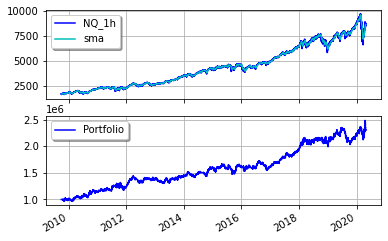

In [20]:
sharpeRatioAnalyzer = sharpe.SharpeRatio()
strat.attachAnalyzer(sharpeRatioAnalyzer)
plot = True
if plot:
    plt = plotter.StrategyPlotter(strat, True, False, True)
    plt.getInstrumentSubplot(instrument).addDataSeries("sma", strat.getSMA())

strat.run()
print("Sharpe ratio: %.2f" % sharpeRatioAnalyzer.getSharpeRatio(0.05))

if plot:
    plt.plot()